In [52]:
%matplotlib inline

In [53]:
from pymatgen.io.cif import CifParser
from pathlib import Path
import numpy as np
from pymatgen.core.periodic_table import DummySpecies, Element
from pymatgen.core.sites import PeriodicSite
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
from matplotlib import pyplot as plt

unit_cell = CifParser(Path(
            "..",
            "defects_generation",
            "molecules",
            "MoS2.cif")).get_structures(primitive=False)[0]
supercell_size = (8, 8, 1)
reference_supercell = unit_cell.copy()
reference_supercell.make_supercell(supercell_size)

/home/kna/.cache/pypoetry/virtualenvs/2d-defects-potential-learning-pYjw2mkT-py3.8/lib/python3.8/site-packages/pymatgen/io/cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [54]:
rng = np.random.RandomState(42)

In [65]:
extreme_defects_freqences = {
    Element("Mo"): {
        Element("W"): 0.5,
        DummySpecies(): 0.05
    },
    Element("S"): {
        Element("Se"): 0.5,
        DummySpecies(): 0.35
    }
}

In [57]:
def get_site_indices_by_species(structure, specie):
    """
    Returns site indices with given specie.
    """
    return [i for i, site in enumerate(structure) if site.specie == specie]

In [60]:
def generate_structure(defects_freqences):
    """
    Creates structure with defects with given frequences.
    """
    supercell = reference_supercell.copy()
    for original_element, this_defects_frequences in defects_freqences.items():
        element_indices = get_site_indices_by_species(reference_supercell, original_element)
        permuted_indices = rng.permutation(element_indices)
        if sum(this_defects_frequences.values()) > 1:
            raise ValueError("Sum of defect frequencies must be less than 1.")
        
        permutation_start = 0
        for defect_specie, defect_frequency in this_defects_frequences.items():
            permutation_end = permutation_start + int(len(element_indices) * defect_frequency)
            for i_np in permuted_indices[permutation_start:permutation_end]:
                i = int(i_np)
                supercell[i] = PeriodicSite(
                    species=defect_specie,
                    coords=supercell[i].coords,
                    lattice=supercell[i].lattice,
                    coords_are_cartesian=True)
            permutation_start = permutation_end
    return supercell

In [70]:
generation_parameters = []
for Mo_W_substitution_frequency in [0.1, 0.3, 0.5, 0.8, 0.9]:
    for S_Se_substitution_frequency in [0.1, 0.3, 0.5, 0.8, 0.9]:
        for Mo_vacancy_frequency in [0, 0.01, 0.05]:
            for S_vacancy_frequency in [0, 0.1, 0.3]:
                generation_parameters.append({
                    Element("Mo"): {
                        Element("W"): Mo_W_substitution_frequency,
                        DummySpecies(): Mo_vacancy_frequency
                    },
                    Element("S"): {
                        Element("Se"): S_Se_substitution_frequency,
                        DummySpecies(): S_vacancy_frequency
                    }
                })

In [ ]:
structures_per_parameters = 200
#for 

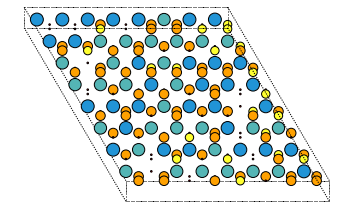

In [69]:
example_structure = generate_structure(extreme_defects_freqences)
ase_atoms = AseAtomsAdaptor.get_atoms(example_structure)
fig, ax = plt.subplots()
plot_atoms(ase_atoms, ax, radii=0.5, rotation=('10x, 0y, 0z'), show_unit_cell=True)
xlim = 40
ylim = 23
ax.set_xlim(-2, xlim)
ax.set_ylim(-2, ylim)
ax.set_axis_off()
fig.savefig("example_structure.png", dpi=300)